In [2]:
import os
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
g = tf.Graph()

with g.as_default():
    x = tf.placeholder(dtype=tf.float32, shape=(None), name='x')
    w = tf.Variable(2.0, name='weight')
    b = tf.Variable(0.7, name='bias')
    
    z=w*x + b
    init=tf.global_variables_initializer()

In [4]:
with tf.Session(graph=g) as sess:
    sess.run(init)
    for t in [1.0, 0.6, -1.8]:
        print(('x=%4.1f --> z=%4.1f'%(t, sess.run(z, feed_dict={x:t}))))

x= 1.0 --> z= 2.7
x= 0.6 --> z= 1.9
x=-1.8 --> z=-2.9


In [5]:
with tf.Session(graph=g) as sess:
    sess.run(init)
    print(sess.run(z, feed_dict={x:[1., 2., 3.]})) 

[2.7 4.7 6.7]


### 配列構造の操作

In [6]:
g = tf.Graph()

with g.as_default():
    x = tf.placeholder(dtype=tf.float32, shape=(None,2,3), name='input_x')
    x2 = tf.reshape(x,shape=(-1,6),name='x2')
    
    print(x2)
    
    ## 各列の合計
    xsum=tf.reduce_sum(x2,axis=0,name='col_sum')
    
    ## 各列の平均
    xmean=tf.reduce_mean(x2,axis=0,name='col_mean')

with tf.Session(graph=g) as sess:
    x_array = np.arange(18).reshape(3,2,3)
    #x_array = np.arange(24).reshape(4,2,3)
    #print('input shape: ', x_array.shape)
    #print('Reshaped:\n', sess.run(x2, feed_dict={x:x_array}))
    print('Column Sums:\n', sess.run(xsum, feed_dict={x:x_array}))
    print('Column Means:\n', sess.run(xmean, feed_dict={x:x_array}))

Tensor("x2:0", shape=(?, 6), dtype=float32)
Column Sums:
 [18. 21. 24. 27. 30. 33.]
Column Means:
 [ 6.  7.  8.  9. 10. 11.]


### 最小2乗線形回帰

In [7]:
X_train = np.arange(10).reshape((10, 1))
y_train = np.array([1.0, 1.3, 3.1,2.0, 5.0, 6.3, 6.6, 7.4, 8.0, 9.0])

In [73]:
class TfLinreg(object):
    
    def __init__(self, x_dim, learning_rate=0.01, random_seed=None):
        self.x_dim = x_dim
        self.learning_rate = learning_rate
        self.g = tf.Graph()
        
        with self.g.as_default():
            tf.set_random_seed(random_seed)
            self.build()
            
            # 変数のイニシャライザ
            self.init_op = tf.global_variables_initializer()
    
    def build(self):
        # プレースホルダ―を定義
        self.X = tf.placeholder(dtype=tf.float32, shape=(None,self.x_dim), name='x_input')
        self.y = tf.placeholder(dtype=tf.float32, shape=(None), name='y_input')
        
        print(self.X) # X_train:1段階のテンソル
        print(self.y) # y_train:2段階のテンソル
        
        # tf.zeros:要素が全て0の行列
        # 1×1のテンソル
        w = tf.Variable(tf.zeros(shape=(1)), name='weight')
        b = tf.Variable(tf.zeros(shape=(1)), name='bias')
        
        self.w = w
        self.b = b
        
        # tf.squeeze:1の次元を削除し、テンソルを1つ下げる関数
        self.z_net = tf.squeeze(w * self.X + b, name='z_net')
        
        # 重みのかかった
        print(self.z_net)
        
        # 検証
        #self.before_test = w * self.X + b
        self.z_net = self.z_net
        
        # tf.square:要素ごとに2乗をとる
        sqr_errors = tf.square(self.y - self.z_net, name='sqr_errors')
        print(sqr_errors)
        
        # tf.reduce_mean:与えたリストに入っている数値の平均値を求める関数
        self.mean_cost = tf.reduce_mean(sqr_errors, name='mean_cost')
        
        ## オプティマイザを作成
        # GradientDescentOptimizer:急速降下法
        optimizer = tf.train.GradientDescentOptimizer(
            learning_rate=self.learning_rate,
            name='GradientDescent'
        )
        
        self.optimizer = optimizer.minimize(self.mean_cost)

In [74]:
lrmodel = TfLinreg(x_dim=X_train.shape[1], learning_rate=0.02)

Tensor("x_input:0", shape=(?, 1), dtype=float32)
Tensor("y_input:0", dtype=float32)
Tensor("z_net:0", dtype=float32)
Tensor("sqr_errors:0", dtype=float32)


In [77]:
### 学習

def train_linreg(sess, model, X_train, y_train, num_epochs=10):
    # 変数の初期化
    sess.run(model.init_op)
    
    training_costs=[]

    # 同じX_trainを10回繰り返す
    for i in range(num_epochs):
        """
        model.optimizer:急速降下法を適用する
        model.X:学習データ(階数2)
        model.y:正解データ(階数1)
        model.z_net:予測値(w * self.X + bから計算)
        model.sqr_errors:実績値-予測値の2乗
        model.mean_cost:2乗誤差の平均値
        model.w:更新後の重み
        model.b:更新後のバイアス
        """
        _, cost, w, b, z_net = sess.run([model.optimizer, model.mean_cost, model.w, model.b, model.z_net],
                            feed_dict={model.X:X_train, model.y:y_train}) # 同じのを10回繰り返す
        training_costs.append(cost)
    
    return training_costs

In [78]:
sess = tf.Session(graph=lrmodel.g)
training_costs = train_linreg(sess, lrmodel, X_train, y_train)

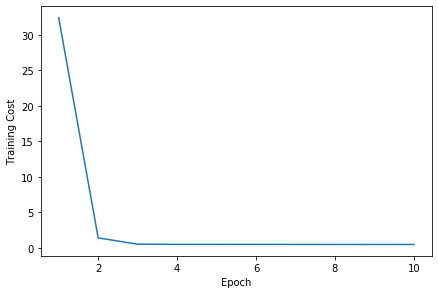

In [79]:
import matplotlib.pyplot as plt

plt.plot(range(1,len(training_costs) + 1), training_costs)
plt.tight_layout()
plt.xlabel('Epoch')
plt.ylabel('Training Cost')
#plt.savefig('images/13_01.png', dpi=300)
plt.show()

In [32]:
### 予測
def predict_linreg(sess, model, X_test):
    y_pred = sess.run(model.z_net, feed_dict={model.X:X_test})
    return y_pred

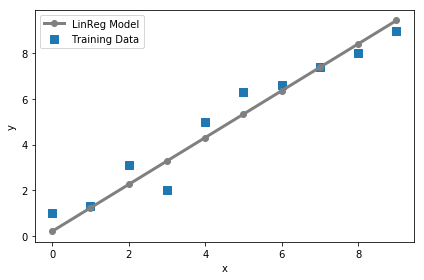

In [20]:
plt.scatter(X_train, y_train,
            marker='s', s=50,
            label='Training Data')
plt.plot(range(X_train.shape[0]), 
         predict_linreg(sess, lrmodel, X_train),
         color='gray', marker='o', 
         markersize=6, linewidth=3,
         label='LinReg Model')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.tight_layout()
#plt.savefig('images/13_02.png')
plt.show()

### TensorFlow Layers

In [21]:
import struct
 
def load_mnist(path, kind='train'):
    labels_path = os.path.join(path, '%s-labels.idx1-ubyte' % kind).replace('\\','/')
    images_path = os.path.join(path, '%s-images.idx3-ubyte' % kind).replace('\\','/')
        
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", 
                                               imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)
        images = ((images / 255.) - .5) * 2
 
    return images, labels

In [22]:
current_path = os.path.join(os.getcwd(),'mnist')
X_train, y_train = load_mnist(current_path, kind='train')
print('Rows: %d,  Columns: %d' %(X_train.shape[0], X_train.shape[1]))

Rows: 60000,  Columns: 784


In [23]:
X_test, y_test = load_mnist(current_path, kind='t10k')
print('Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

Rows: 10000, columns: 784


In [24]:
# 平均&標準化
mean_vals = np.mean(X_train, axis=0)
std_val = np.std(X_train)

# 中心化
X_train_centered = (X_train - mean_vals)/std_val
X_test_centered = (X_test - mean_vals)/std_val

del X_train, X_test

print(X_train_centered.shape, y_train.shape)
print(X_test_centered.shape, y_test.shape)

(60000, 784) (60000,)
(10000, 784) (10000,)


In [31]:
import tensorflow as tf

n_features = X_train_centered.shape[1]
n_classes = 10
random_seed = 123
np.random.seed(random_seed)

g = tf.Graph()

with g.as_default():
    tf.set_random_seed(random_seed)
    tf_x = tf.placeholder(dtype=tf.float32,shape=(None, n_features),name='tf_x')
    tf_y = tf.placeholder(dtype=tf.int32, shape=None, name='tf_y')
    
    # tf.one_hot:ワンホット表現に置き換える
    y_onehot = tf.one_hot(indices=tf_y, depth=n_classes)
    
    # tf.layers.dense:全結合層
    h1 = tf.layers.dense(inputs=tf_x, units=50,activation=tf.tanh,name='layer1')
    h2 = tf.layers.dense(inputs=h1, units=50,activation=tf.tanh,name='layer2')
    # 追加した隠れ層
    logits = tf.layers.dense(inputs=h2, units=10,activation=None,name='layer3')
    
    # 出力層のソフトマックス関数(元はロジスティック関数)
    predictions = {
        'classes' : tf.argmax(logits, axis=1, name='predicted_classes'),
        'probabilities' : tf.nn.softmax(logits, name='softmax_tensor')
    } 

In [32]:
with g.as_default():
    # コスト関数
    cost = tf.losses.softmax_cross_entropy(onehot_labels=y_onehot,
                                          logits=logits)
    ## オプティマイザを作成
    # GradientDescentOptimizer:急速降下法
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
    train_op = optimizer.minimize(loss=cost)
    init_op = tf.global_variables_initializer()

In [33]:
# データバッチ生成用のジェネレーター
def create_batch_generator(X, y, batch_size=128, shuffle=False):
    X_copy = np.array(X)
    y_copy = np.array(y)
    
    if shuffle:
        # np.column_stack:配列を列方向に積み上げる
        data = np.column_stack((X_copy, y_copy))
        np.random.shuffle(data)
        X_copy = data[:, :-1]
        y_copy = data[:, :-1].astype(int)
        
    for i in range(0, X.shape[0], batch_size):
        yield (X_copy[i:i+batch_size, :], y_copy[i:i+batch_size])

In [34]:
# TensorFlowのセッション開始
sess = tf.Session(graph=g)
sess.run(init_op)

# 50エポックのトレーニング
training_costs=[]
for epoch in range(50):
    training_loss=[]
    batch_generator=create_batch_generator(X_train_centered, y_train, batch_size=64)
    
    for batch_X, batch_y in batch_generator:
        feed={tf_x:batch_X, tf_y:batch_y}
        _, batch_cost = sess.run([train_op, cost], feed_dict=feed)
        training_costs.append(batch_cost)
    print(' -- Epoch %2d  Avg. Training Loss: %.4f' % (epoch+1, np.mean(training_costs)))

 -- Epoch  1  Avg. Training Loss: 1.5573
 -- Epoch  2  Avg. Training Loss: 1.2532
 -- Epoch  3  Avg. Training Loss: 1.0854
 -- Epoch  4  Avg. Training Loss: 0.9738
 -- Epoch  5  Avg. Training Loss: 0.8924
 -- Epoch  6  Avg. Training Loss: 0.8296
 -- Epoch  7  Avg. Training Loss: 0.7794
 -- Epoch  8  Avg. Training Loss: 0.7381
 -- Epoch  9  Avg. Training Loss: 0.7032
 -- Epoch 10  Avg. Training Loss: 0.6734
 -- Epoch 11  Avg. Training Loss: 0.6475
 -- Epoch 12  Avg. Training Loss: 0.6247
 -- Epoch 13  Avg. Training Loss: 0.6045
 -- Epoch 14  Avg. Training Loss: 0.5864
 -- Epoch 15  Avg. Training Loss: 0.5700
 -- Epoch 16  Avg. Training Loss: 0.5551
 -- Epoch 17  Avg. Training Loss: 0.5415
 -- Epoch 18  Avg. Training Loss: 0.5290
 -- Epoch 19  Avg. Training Loss: 0.5175
 -- Epoch 20  Avg. Training Loss: 0.5068
 -- Epoch 21  Avg. Training Loss: 0.4968
 -- Epoch 22  Avg. Training Loss: 0.4875
 -- Epoch 23  Avg. Training Loss: 0.4788
 -- Epoch 24  Avg. Training Loss: 0.4706
 -- Epoch 25  Av

In [35]:
# テストデータセットで予測を行う
feed = {tf_x : X_test_centered}
y_pred = sess.run(predictions['classes'], feed_dict=feed)
print('Test Accuracy: %.2f%%' % (100*np.sum(y_pred == y_test)/y_test.shape[0]))

Test Accuracy: 93.89%
